In [6]:
import jsonlines
import os

In [27]:
file_path = '/media/mlfavorfit/sdb/contolnet_dataset/control_net_train/train.jsonl'

text_dict = {}
with jsonlines.open(file_path, 'r') as reader:
    for obj in reader:
        text_dict[obj["image"]] = obj["text"]

In [30]:
image_dir = "images"
condition_dir = "conditioning_images"
text_dict = text_dict

def preprocess_line(obj):
    dn = os.path.basename(os.path.dirname(obj['fn']))
    fn = dn + "_" + os.path.basename(obj['fn']) + ".jpg"

    image_fn = os.path.join(image_dir, fn)
    condition_fn = os.path.join(condition_dir, fn)
    return {"image":image_fn, 
            "conditioning_images":condition_fn, 
            "obj_colors":obj["obj_colors"], 
            "bg_colors":obj["bg_colors"], 
            "total_colors":obj["total_colors"],
            "text":text_dict[image_fn]}

In [32]:
file_path = '/home/mlfavorfit/lib/favorfit/kjg/color_and_template_recommendation/favorfit_product_color_datas.jsonl'

data_list = []
with jsonlines.open(file_path, 'r') as reader:
    for obj in reader:
        data_list.append(preprocess_line(obj))

In [36]:
file_path = 'output_jsonline_file.jsonl'  # 쓰기용 파일 경로를 적절하게 수정하세요.

with jsonlines.open(file_path, 'w') as writer:
    writer.write_all(data_list)

In [1]:
from diffusion import UNET

unet = UNET(is_lora=True)
my_model = unet.state_dict()

In [2]:
my_model_lora = my_model.copy()
for cur in my_model.keys():
    if "lora" not in cur:
        my_model_lora.pop(cur)

In [20]:
from safetensors.torch import load_file

pre_model = load_file("/home/mlfavorfit/lib/favorfit/kjg/0_model_weights/diffusion/lora/FavorfitStyle.safetensors")

In [34]:
lns = {"encoders":"down_blocks", "bottleneck":"mid_block", "decoders":"up_blocks"}
qkv = ["k","q","v","out"]
ud = ["up","down"]
encoder_layer_map = {1:(0,0), 2:(0,1), 4:(1,0), 5:(1,1), 7:(2,0), 8:(2,1)}
decoder_layer_map = {3:(1,0), 4:(1,1), 5:(1,2), 
                     6:(2,0), 7:(2,1), 8:(2,2),
                     9:(3,0), 10:(3,1), 11:(3,2),}

weight_map = []
for ln in lns.keys():
    if ln == "encoders":
        for layer in encoder_layer_map.keys():
            for attn in [1,2]:
                for t in qkv:
                    for d in ud:
                        weight_map.append(
                            (f"{ln}.{layer}.1.attention_{attn}.{t}_lora_{d}.weight",
                                f"{lns[ln]}.{encoder_layer_map[layer][0]}.attentions.{encoder_layer_map[layer][1]}.transformer_blocks.0.attn{attn}.processor.to_{t}_lora.{d}.weight")
                        )
    elif ln == "decoders":
        for layer in decoder_layer_map.keys():
            for attn in [1,2]:
                for t in qkv:
                    for d in ud:
                        weight_map.append(
                            (f"{ln}.{layer}.1.attention_{attn}.{t}_lora_{d}.weight",
                                f"{lns[ln]}.{decoder_layer_map[layer][0]}.attentions.{decoder_layer_map[layer][1]}.transformer_blocks.0.attn{attn}.processor.to_{t}_lora.{d}.weight")
                        )
    else:
        for attn in [1,2]:
            for t in qkv:
                for d in ud:
                    weight_map.append(
                        (f"{ln}.1.attention_{attn}.{t}_lora_{d}.weight",
                            f"{lns[ln]}.attentions.0.transformer_blocks.0.attn{attn}.processor.to_{t}_lora.{d}.weight")
                    )

In [35]:
new_model_weight = {}
for my_key, pre_key in weight_map:
    if my_model_lora[my_key].shape == pre_model[pre_key].shape:
        new_model_weight[my_key] = pre_model[pre_key]
    else:
        print(my_model_lora[my_key].shape, pre_model[pre_key].shape)
        print((my_key, pre_key))

In [39]:
len(new_model_weight) == len(pre_model)

True

In [40]:
from safetensors.torch import save_file

save_file(new_model_weight, "my_own_lora.safetensors")

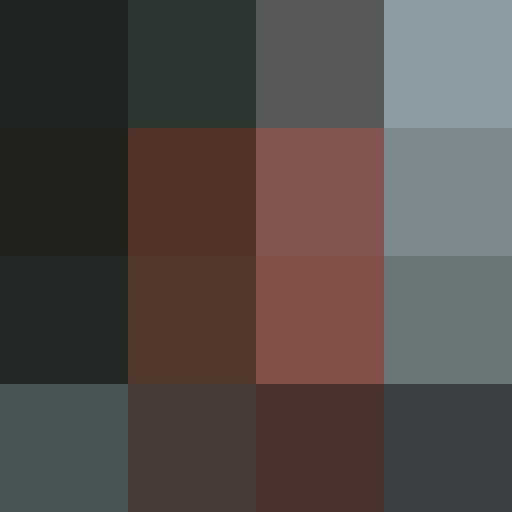

In [5]:
from PIL import Image
import numpy as np

def convert_to_tiles(image_path, tile_size):
    # 이미지 열기
    img = Image.open(image_path).resize([512,512])

    # 이미지 크기 가져오기
    width, height = img.size

    # 8x8 타일 크기 설정
    tile_width, tile_height = tile_size

    # 타일별로 이미지를 자르고 각 타일의 평균 색상 계산
    for y in range(0, height, tile_height):
        for x in range(0, width, tile_width):
            # 타일 자르기
            tile = img.crop((x, y, x + tile_width, y + tile_height))

            # 타일의 평균 색상 계산
            average_color = np.array(tile).mean(axis=(0, 1)).astype(int)

            # 타일에 평균 색상 적용
            tile = Image.fromarray(np.full((tile_height, tile_width, 3), average_color, dtype=np.uint8))

            # 원본 이미지에 타일 적용
            img.paste(tile, (x, y, x + tile_width, y + tile_height))

    # 결과 이미지 저장 또는 표시
    # img.show()
    return img

# 이미지 경로와 타일 크기 설정
image_path = './images/bottle.jpg'  # 이미지 파일 경로로 바꾸세요
tile_size = (512//4, 512//4)

# 함수 호출
convert_to_tiles(image_path, tile_size)

In [ ]:
from glob import glob
from tqdm import tqdm
import os

tile_size = (512//8, 512//8)

fns = glob("/media/mlfavorfit/sdb/contolnet_dataset/control_net_train_base/images/*")
save_dir = "/media/mlfavorfit/sdb/contolnet_dataset/temp"
for fn in tqdm(fns, total=len(fns)):
    img = convert_to_tiles(fn, tile_size)
    img.save(os.path.join(save_dir, os.path.basename(fn)))

In [3]:
save_dir = "/media/mlfavorfit/sdb/contolnet_dataset/temp3"

def combine_images(img_fn, mask_fn, color_fn):
    fn = os.path.basename(img_fn)
    img = np.array(Image.open(img_fn).convert("RGB"))
    mask = np.array(Image.open(mask_fn).convert("RGB"))
    color = np.array(Image.open(color_fn).convert("RGB"))

    result_np = img * (mask/255.0) + color * (1-mask/255.0)
    result_image = Image.fromarray(result_np.astype(np.uint8))
    
    result_image.save(os.path.join(save_dir, fn))

In [6]:
image_fns = glob("/media/mlfavorfit/sdb/product_512_dataset/images/*.jpg")
mask_fns = glob("/media/mlfavorfit/sdb/product_512_dataset/masks/*.jpg")
color_fns = glob("/media/mlfavorfit/sdb/contolnet_dataset/control_net_train_base/conditioning_images_8x8/*.jpg")

for img_fn, mask_fn, color_fn in tqdm(zip(image_fns, mask_fns, color_fns), total=len(image_fns)):
    img = combine_images(img_fn, mask_fn, color_fn)
    break

  0%|          | 0/197967 [00:00<?, ?it/s]


In [7]:
import torch

controlent_dict = torch.load("./checkpoint-115000/controlnet_1.pth")
embedding_dict = torch.load("./checkpoint-115000/embedding_1.pth")
total_dict = {"controlnet":controlent_dict, "embedding": embedding_dict}

torch.save(total_dict, "./controlnet_colot_tile.pth")

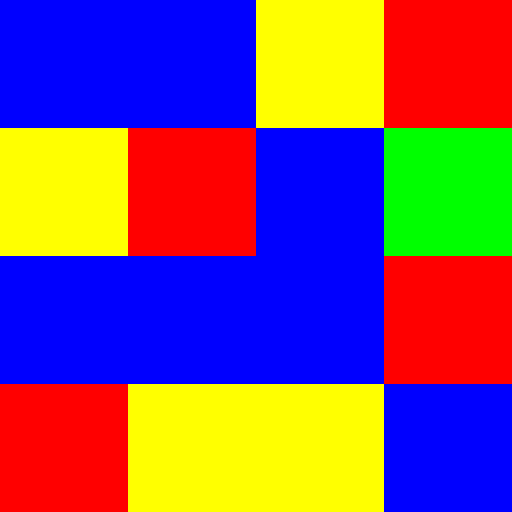

In [9]:
from PIL import Image
import random

def convert_to_random_color_tiles(colors, image_size=[512,512], tile_num_per_row=4):
    # 이미지 열기
    img = Image.new('RGB', image_size)

    # 이미지 크기 가져오기
    width, height = img.size
    tile_size = (512//tile_num_per_row, 512//tile_num_per_row)

    # 타일별로 이미지를 자르고 랜덤한 색상의 타일로 대체
    for y in range(0, height, tile_size[1]):
        for x in range(0, width, tile_size[0]):
            # 랜덤하게 색상 섞기
            random.shuffle(colors)

            # 랜덤한 타일 생성
            tile = Image.new('RGB', tile_size, tuple(colors[0]))

            # 원본 이미지에 랜덤한 타일 적용
            img.paste(tile, (x, y, x + tile_size[0], y + tile_size[1]))

    # 결과 이미지 저장 또는 표시
    # img.show()
    return img


colors = [
    (255, 0, 0),  # 빨간색
    (0, 255, 0),  # 초록색
    (0, 0, 255),  # 파란색
    (255, 255, 0),  # 노란색
]

# 함수 호출
convert_to_random_color_tiles(colors, image_size=[512,512], tile_num_per_row=4)


In [245]:
import torch
import torch.nn as nn

In [246]:
class CModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.C_layer1 = nn.Linear(8,4)
        self.C_layer2 = nn.Linear(4,2)
    
    def forward(self, x):
        x = self.C_layer1(x)
        x = self.C_layer2(x)
        return x
    

class AModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(2,4)
        self.layer2 = nn.Linear(4,8)
        self.C = CModel()
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.C(x)
        return x
    def get_C(self):
        return self.C

In [247]:
model_a = AModel()
a_state_dict = model_a.state_dict()

In [248]:
model_a.requires_grad_(False)

AModel(
  (layer1): Linear(in_features=2, out_features=4, bias=True)
  (layer2): Linear(in_features=4, out_features=8, bias=True)
  (C): CModel(
    (C_layer1): Linear(in_features=8, out_features=4, bias=True)
    (C_layer2): Linear(in_features=4, out_features=2, bias=True)
  )
)

In [249]:
class WrappedModel(nn.Module):
    def __init__(self, state_dict) -> None:
        super().__init__()
        for key, value in state_dict.items():
            setattr(self, key, value)

In [250]:
processor = {}

def recursice_named_children(name, cur_module):
    for subname, module in cur_module.named_children():
        recursice_named_children(f"{name}.{subname}",module)
        if "C" in subname:
            processor[f"{name}.{subname}"] = module

In [251]:
cur_modules = model_a.named_children()

In [256]:
cur_model = iter(cur_modules).__next__()
cur_model

('C',
 CModel(
   (C_layer1): Linear(in_features=8, out_features=4, bias=True)
   (C_layer2): Linear(in_features=4, out_features=2, bias=True)
 ))

In [257]:
recursice_named_children(cur_model[0], cur_model[1])

In [258]:
processor

{'C.C_layer1': Linear(in_features=8, out_features=4, bias=True),
 'C.C_layer2': Linear(in_features=4, out_features=2, bias=True)}

In [274]:
wrapped_model = WrappedModel(processor)
wrapped_model.requires_grad_(True)

WrappedModel(
  (C.C_layer1): Linear(in_features=8, out_features=4, bias=True)
  (C.C_layer2): Linear(in_features=4, out_features=2, bias=True)
)

In [275]:
wrapped_model

WrappedModel(
  (C.C_layer1): Linear(in_features=8, out_features=4, bias=True)
  (C.C_layer2): Linear(in_features=4, out_features=2, bias=True)
)

In [276]:
from accelerate import Accelerator

accelerator = Accelerator()

In [277]:
import torch
from torch.utils.data import Dataset, DataLoader

class SimpleDataset(Dataset):
    def __init__(self, num_samples):
        samples = []
        for _ in range(num_samples):
            x = torch.rand(1)  # x는 랜덤 값
            y = torch.rand(1)  # y는 랜덤 값
            a = 3 * x + 2 * y
            b = torch.rand(1)  # b는 랜덤 값

            samples.append({'input': torch.cat([x, y]), 'output': torch.cat([a, b])})
        self.samples = samples
        self.num_samples = num_samples
        
    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        temp_dict = self.samples[idx]
        return temp_dict["input"], temp_dict["output"]

# 데이터셋 생성
num_samples = 10
simple_dataset = SimpleDataset(num_samples)

# 데이터로더 생성
batch_size = 2
train_dataloader = DataLoader(simple_dataset, batch_size=batch_size, shuffle=True)

In [278]:
optimizer = torch.optim.AdamW(
            wrapped_model.parameters(),
            lr=0.1,
            betas=(0.9, 0.999),
            weight_decay=1e-2,
            eps=1e-08,
        )
from torch.optim.lr_scheduler import LambdaLR
lr_scheduler = LambdaLR(optimizer, lambda _: 1)

In [279]:
wrapped_model, optimizer, train_dataloader, lr_scheduler = accelerator.prepare(
        wrapped_model, optimizer, train_dataloader, lr_scheduler
    )

In [280]:
model_a.to("cuda")

AModel(
  (layer1): Linear(in_features=2, out_features=4, bias=True)
  (layer2): Linear(in_features=4, out_features=8, bias=True)
  (C): CModel(
    (C_layer1): Linear(in_features=8, out_features=4, bias=True)
    (C_layer2): Linear(in_features=4, out_features=2, bias=True)
  )
)

In [284]:
for epoch in range(100):
    for x, y in train_dataloader:
        x = x.to("cuda")
        y = y.to("cuda")
        out = model_a(x)

        loss = torch.nn.functional.mse_loss(out, y, reduction="mean")

        accelerator.backward(loss)
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad(set_to_none=False)

    print(f"Epoch {epoch}, {loss}")

Epoch 0, 0.05174887925386429
Epoch 1, 0.07386156171560287
Epoch 2, 0.018628951162099838
Epoch 3, 0.03663861006498337
Epoch 4, 0.022263865917921066
Epoch 5, 0.062061410397291183
Epoch 6, 0.040121085941791534
Epoch 7, 0.019479941576719284
Epoch 8, 0.03244991600513458
Epoch 9, 0.057142555713653564
Epoch 10, 0.015966355800628662
Epoch 11, 0.03696296736598015
Epoch 12, 0.08301135152578354
Epoch 13, 0.0877738744020462
Epoch 14, 0.029905393719673157
Epoch 15, 0.007747014053165913
Epoch 16, 0.1424693614244461
Epoch 17, 0.015622764825820923
Epoch 18, 0.037107523530721664
Epoch 19, 0.05418482422828674
Epoch 20, 0.01611332967877388
Epoch 21, 0.017393141984939575
Epoch 22, 0.014837323687970638
Epoch 23, 0.028957057744264603
Epoch 24, 0.01763251982629299
Epoch 25, 0.016636045649647713
Epoch 26, 0.008520846255123615
Epoch 27, 0.0018330835737287998
Epoch 28, 0.039698194712400436
Epoch 29, 0.05326563119888306
Epoch 30, 0.039649829268455505
Epoch 31, 0.03293096646666527
Epoch 32, 0.03263557329773903
Ep

In [285]:
model_a.state_dict()

OrderedDict([('layer1.weight',
              tensor([[ 0.0649, -0.4435],
                      [-0.0644,  0.4817],
                      [-0.5576, -0.1599],
                      [-0.6445,  0.1108]], device='cuda:0')),
             ('layer1.bias',
              tensor([ 0.4020,  0.1738, -0.3677,  0.3300], device='cuda:0')),
             ('layer2.weight',
              tensor([[-0.1744,  0.0382,  0.2159,  0.4484],
                      [-0.4703,  0.1845,  0.3628, -0.0399],
                      [ 0.3475,  0.1668, -0.2921,  0.4301],
                      [-0.1527,  0.0454,  0.0541, -0.3027],
                      [-0.2219, -0.2032,  0.2916,  0.2315],
                      [-0.4922, -0.2139, -0.0118,  0.1270],
                      [-0.1604,  0.1043, -0.2793,  0.2810],
                      [ 0.3029, -0.2067, -0.3825,  0.1868]], device='cuda:0')),
             ('layer2.bias',
              tensor([ 0.2963, -0.3305, -0.0682, -0.1248, -0.4390, -0.3795,  0.0197, -0.4016],
                   

In [283]:
model_a.state_dict()

OrderedDict([('layer1.weight',
              tensor([[ 0.0649, -0.4435],
                      [-0.0644,  0.4817],
                      [-0.5576, -0.1599],
                      [-0.6445,  0.1108]], device='cuda:0')),
             ('layer1.bias',
              tensor([ 0.4020,  0.1738, -0.3677,  0.3300], device='cuda:0')),
             ('layer2.weight',
              tensor([[-0.1744,  0.0382,  0.2159,  0.4484],
                      [-0.4703,  0.1845,  0.3628, -0.0399],
                      [ 0.3475,  0.1668, -0.2921,  0.4301],
                      [-0.1527,  0.0454,  0.0541, -0.3027],
                      [-0.2219, -0.2032,  0.2916,  0.2315],
                      [-0.4922, -0.2139, -0.0118,  0.1270],
                      [-0.1604,  0.1043, -0.2793,  0.2810],
                      [ 0.3029, -0.2067, -0.3825,  0.1868]], device='cuda:0')),
             ('layer2.bias',
              tensor([ 0.2963, -0.3305, -0.0682, -0.1248, -0.4390, -0.3795,  0.0197, -0.4016],
                   

In [64]:
accelerator.unwrap_model(wrapped_model)

WrappedModel(
  (C.C_layer1): Linear(in_features=8, out_features=4, bias=True)
  (C.C_layer2): Linear(in_features=4, out_features=2, bias=True)
)

In [65]:
wrapped_model.state_dict()

OrderedDict([('C.C_layer1.weight',
              tensor([[ 4.1467,  0.4966,  1.7386, -0.3810,  0.2673, -0.9106,  1.8412, -0.0341],
                      [ 2.8152,  0.4204,  1.2243, -0.5114,  0.4369, -0.6324,  1.8980, -0.0629],
                      [-0.2590, -0.0796, -0.1273, -0.0409, -0.0426, -0.0321, -0.6010, -0.0057],
                      [ 3.2758,  0.6608,  1.3855, -0.4597,  0.3026, -0.6473,  2.0962, -0.0068]],
                     device='cuda:0')),
             ('C.C_layer1.bias',
              tensor([ 0.1723,  0.1349, -0.0129,  0.0912], device='cuda:0')),
             ('C.C_layer2.weight',
              tensor([[ 1.0318,  0.9485, -0.0579,  0.8989],
                      [-0.1322, -0.0972,  0.0012, -0.1086]], device='cuda:0')),
             ('C.C_layer2.bias', tensor([0.9125, 0.7507], device='cuda:0'))])

In [125]:
from model_loader import load_diffusion_model

kwargs = {"is_lora":True, "lora_scale":1.0}
models = load_diffusion_model(**kwargs)

In [127]:
module_list = models['diffusion'].named_children()

In [132]:
cur_module = iter(module_list).__next__()

In [138]:
processor = {}

def recursice_named_children(name, cur_module):
    for subname, module in cur_module.named_children():
        recursice_named_children(f"{name}.{subname}",module)
        if "lora" in subname:
            processor[f"{name}.{subname}"] = module

In [140]:
recursice_named_children(cur_module[0], cur_module[1])

In [143]:
processor

{'unet.encoders.1.1.attention_1.k_lora_down': Linear(in_features=320, out_features=4, bias=False),
 'unet.encoders.1.1.attention_1.k_lora_up': Linear(in_features=4, out_features=320, bias=False),
 'unet.encoders.1.1.attention_1.q_lora_down': Linear(in_features=320, out_features=4, bias=False),
 'unet.encoders.1.1.attention_1.q_lora_up': Linear(in_features=4, out_features=320, bias=False),
 'unet.encoders.1.1.attention_1.v_lora_down': Linear(in_features=320, out_features=4, bias=False),
 'unet.encoders.1.1.attention_1.v_lora_up': Linear(in_features=4, out_features=320, bias=False),
 'unet.encoders.1.1.attention_1.out_lora_down': Linear(in_features=320, out_features=4, bias=False),
 'unet.encoders.1.1.attention_1.out_lora_up': Linear(in_features=4, out_features=320, bias=False),
 'unet.encoders.1.1.attention_2.k_lora_down': Linear(in_features=768, out_features=4, bias=False),
 'unet.encoders.1.1.attention_2.k_lora_up': Linear(in_features=4, out_features=320, bias=False),
 'unet.encoders.

In [190]:
import json

color_list = {}
with open("/home/mlfavorfit/lib/favorfit/shlee/favorfit_color_recommendation/features/list_of_colors.jsonl", mode="r") as file:
    for line in file:
        line = json.loads(line)
        color_list[line["color_number"]] = line["color_rgb"]

color_list = [cur[1] for cur in sorted(color_list.items(), key=lambda x:x[0])]

In [234]:
def extract_euclidien_similarity(data_arr):
    data_arr = np.array(data_arr)
    norm_data = np.sum(data_arr ** 2, axis=1).reshape(-1, 1)
    squared_distances = norm_data + norm_data.T - 2 * np.dot(data_arr, data_arr.T)
    squared_distances = np.maximum(squared_distances, 0)
    distances = np.sqrt(squared_distances)
    similarities = 1 / (1 + distances)
    np.fill_diagonal(similarities, 1)
    
    return similarities

def get_color_tokens(palette):
    palette = np.array(palette)
    color_array = np.array(color_list)+1

    rgb_results = []
    id_results = []
    for target in palette:
        similarities = extract_euclidien_similarity(np.concatenate([target[None,:], color_array]))[0][1:]

        id_results.append(np.argmax(similarities).tolist())
        rgb_results.append((color_array[np.argmax(similarities)]-1).tolist())
        
    return rgb_results, id_results

In [241]:
img_color_features = []
with open("/media/mlfavorfit/sdb/contolnet_dataset/control_net_train_base/favorfit_product_color_train.jsonl", mode="r") as file:
    for line in file:
        line = json.loads(line)
  
        rgb_results, id_results = get_color_tokens(line["obj_colors"][0])
        img_color_features.append({"image":line["image"], 
                                   "obj_colors":line["obj_colors"][0], 
                                   "cluster_colors":rgb_results,
                                   "cluster_colors_id":id_results})

In [244]:
with open("temp.json", mode="w") as f:
    json.dump(img_color_features, f, indent=4)

In [168]:
import matplotlib.pyplot as plt
def visualize_rgb_colors(rgb_colors):
    rgb_colors = np.array(rgb_colors)

    # Create a figure and axis for the plot
    fig, ax = plt.subplots()

    # Loop through the list of BGR colors and plot each one
    for i, color in enumerate(rgb_colors):
        # Convert BGR to RGB and normalize to [0, 1]
        rgb_color = [x / 255.0 for x in color]

        # Create a rectangle filled with the normalized RGB color
        rect = plt.Rectangle((i, 0), 1, 1, facecolor=rgb_color)
        
        # Add the rectangle to the plot
        ax.add_patch(rect)

    # Set axis limits and aspect ratio
    ax.set_xlim(0, len(rgb_colors))
    ax.set_ylim(0, 1)
    ax.set_aspect('equal')

    # Remove axis labels and ticks
    ax.set_xticks([])
    ax.set_yticks([])

    # Show the plot
    plt.show()

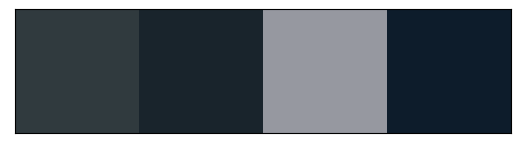

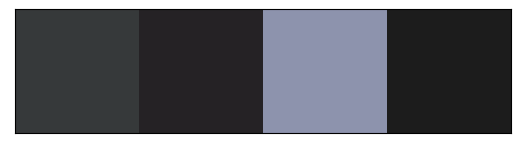

In [220]:
visualize_rgb_colors(img_color_features[0]["obj_colors"])
visualize_rgb_colors(img_color_features[0]["cluster_colors"])